In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from lightkurve import search_lightcurvefile

In [2]:
star = 'AB Dor'
lcf = search_lightcurvefile(star, mission='TESS').download_all()

In [3]:
lc = lcf.PDCSAP_FLUX.stitch()

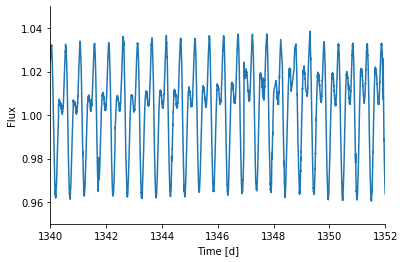

In [4]:
plt.plot(lc.time, lc.flux)
plt.xlim([1340, 1352])
plt.ylim([0.95, 1.05])
for sp in 'right top'.split():
    plt.gca().spines[sp].set_visible(False)
    
plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.savefig('plots/abdor.png', bbox_inches='tight', dpi=250)

In [5]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

In [97]:
max_time = 1365 + 20 #1352
min_time = 1350 + 20
skip = 5

t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

<ErrorbarContainer object of 3 artists>

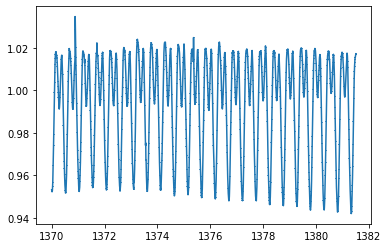

In [98]:
plt.errorbar(t1, f1, e1)

In [99]:
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner

e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

In [100]:
# shear = 0.2
# lat = np.pi * 0.1
# eq_period = 5
# period_i = eq_period / (1 - shear * np.sin(lat - np.pi/2)**2)

In [ ]:
n_spots = 2

with pm.Model(name=f'{n_spots}') as model1:

    f0 = pm.Uniform("f0", lower=0, upper=1)
    nu = pm.Uniform("nu", lower=1, upper=5)    
    spot_model = 1 + f0
    #eq_period = pm.Uniform("P_eq", lower=0.2, upper=0.3)
    eq_period = pm.Uniform("P_eq", lower=0.4, upper=0.6)
    shear = pm.Uniform("shear", lower=0., upper=0.2)
    inclination = 90-60
    
    for spot_ind in range(n_spots):
        latitude_cutoff = 10
#         contrast = pm.Uniform(f"contrast_{spot_ind}", lower=0.1, upper=0.8)
        lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
        lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
        rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.1, upper=0.8)

        period_i = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)
        phi = 2 * np.pi / period_i * (t1 - t1.mean()) - lon

        spot_position_x = (pm.math.cos(phi - np.pi/2) * pm.math.sin(np.radians(inclination)) * pm.math.sin(lat) + 
                           pm.math.cos(np.radians(inclination)) * pm.math.cos(lat))
        spot_position_y = -pm.math.sin(phi - np.pi/2) * pm.math.sin(lat)
        spot_position_z = (pm.math.cos(lat) * pm.math.sin(np.radians(inclination)) - pm.math.sin(phi) * 
                           pm.math.cos(np.radians(inclination)) * pm.math.sin(lat))

        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.4
        spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)
    
    pm.StudentT("obs", mu=spot_model, nu=nu,
                sigma=e1_tt,
                observed=f1)
    
    trace1 = sample_smc(5000, n_steps=2, #random_seed=0, 
                        cores=8, parallel=True, threshold=0.2)

#     trace1 = pm.sample(100, cores=8)

Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
INFO:pymc3:Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:   2 Acce: 0.354
INFO:pymc3:Stage:   1 Beta: 0.001 Steps:   2 Acce: 0.354


In [ ]:
# def numpy_model_seq(lat, lon, rspot, f0, per, shear, contrast=0.7, inclination=45):
    
#     spot_model = 1 + f0
#     eq_period = per
#     for i in range(len(lon)):
#         period_i = eq_period / (1 - shear * np.sin(lat[i] - np.pi/2)**2)
#         theta = lat[i] #- np.pi/2
#         phi =  2 * np.pi / period_i * (t1 - t1.mean()) - lon[i]
#         spot_position_x = (np.cos(phi - np.pi/2) * np.sin(np.radians(inclination)) * np.sin(theta) + 
#                            np.cos(np.radians(inclination)) * np.cos(theta))
#         spot_position_y = -(np.sin(phi - np.pi/2) * np.sin(theta))
#         spot_position_z = np.cos(theta) * np.sin(np.radians(inclination)) - np.sin(phi) * np.cos(np.radians(inclination)) * np.sin(theta)

#         rsq = (spot_position_x**2 + spot_position_y**2)
#         tmp = np.sqrt(1 - rsq)
#         spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, tmp, 0) 

#     return spot_model, spot_position_z

In [ ]:
with model1:
    ppc = pm.sample_posterior_predictive(trace1, samples=100)

In [ ]:
plt.figure(figsize=(20, 3))
plt.errorbar(t1, f1, e1, fmt='.', color='k')

# samples = pm.trace_to_dataframe(trace1).values

# for s in samples[np.random.randint(0, samples.shape[0], size=10)]:
#     f0, per, shear, lon, lat, rspot = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
#     print(f0, per, shear, lon, lat, rspot)
#     model, spot_position_z = numpy_model_seq(lat, lon, rspot, f0, per, shear, inclination=90-60)
#     plt.plot(t1, model, alpha=1)
# #     plt.plot(t1, spot_position_z)

plt.plot(t1, ppc[f'{n_spots}_obs'].T, color='DodgerBlue', lw=2, alpha=0.1)
plt.ylim([0.92, 1.05])

plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.show()

In [ ]:
# from interpacf import interpolated_acf

# lag, acf = interpolated_acf(t1, f1-f1.mean())

# plt.plot(lag, acf)

In [ ]:
corner(pm.trace_to_dataframe(trace1));

In [ ]:
import healpy as hp

NSIDE = 2**8

NPIX = hp.nside2npix(NSIDE)

m = np.zeros(NPIX)

samples = pm.trace_to_dataframe(trace1).values

for lon, lat, rspot in np.median(samples[:, 4:], axis=0).reshape((n_spots, 3)):
    print(lon, lat)
    spot_vec = hp.ang2vec(np.pi - lat, lon)
    ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
    m[ipix_spots] = 1 - contrast

cmap = plt.cm.Greys
cmap.set_under('w')

hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
            max=1.0, notext=True, flip='geo')
hp.graticule(color='silver')
plt.show()

In [ ]:
# # lats = np.array([np.pi/2, np.pi/2])
# # lons = np.array([0, np.pi])
# # rads = np.array([0.01, 0.05])

# lats = np.array([np.pi * 0.05])
# lons = np.array([0])
# rads = np.array([0.01])

# inclination = 90
# seq = numpy_model_seq(lats, lons, rads, 0., 0.51, 0.0, inclination=90-inclination)[0]
# plt.plot(t1, seq)

# phases = ((t1 - t1.mean()) % 0.51) / 0.51

# from fleck import Star

# s = Star(0.7, [0, 0], rotation_period=0.51, phases=phases)
# lc = s.light_curve(
#     (lons + 1.5 * np.pi)[:, None] * u.rad, 
#     u.rad * np.pi/2 - lats[:, None] * u.rad, 
#     rads[:, None], 
#     inc_stellar=inclination*u.deg,
#     times=t1, time_ref=t1.mean(),
# )[:, 0]
# plt.plot(t1, lc, '--')
# plt.xlim([1360, 1362])

In [ ]:
# from astropy.coordinates import (CartesianRepresentation,
#                                  UnitSphericalRepresentation)
# from astropy.coordinates.matrix_utilities import rotation_matrix

# usr = UnitSphericalRepresentation((lons + np.pi/2)[:, None] * u.rad, u.rad * np.pi/2 - lats[:, None] * u.rad)

# # Represent those spots with cartesian coordinates (x, y, z)
# # In this coordinate system, the observer is at positive x->inf,
# # the star is at the origin, and (y, z) is the sky plane.
# cartesian = usr.represent_as(CartesianRepresentation)

# # Generate array of rotation matrices to rotate the spots about the
# # stellar rotation axis
# times = t1
# time_ref = t1.mean()
# rotation_period = 0.51
# rotational_phase = 2 * np.pi * ((times - time_ref) /
#                                 rotation_period) * u.rad
# rotate = rotation_matrix(rotational_phase[:, np.newaxis, np.newaxis],
#                          axis='z')

# rotated_spots = cartesian.transform(rotate)

# inc_stellar = inclination * u.deg
# # Generate array of rotation matrices to rotate the spots so that the
# # star is observed from the correct stellar inclination
# stellar_inclination = rotation_matrix(inc_stellar - 90*u.deg, axis='y')
# inclined_spots = rotated_spots.transform(stellar_inclination)

In [ ]:


# theta = lats[0]
# period = 0.51
# phi = 2 * np.pi / period * (t1 - t1.mean()) - lons[0]
# spot_position_x = (np.cos(phi - np.pi/2) * np.sin(np.radians(inclination)) * np.sin(theta) + 
#                    np.cos(np.radians(inclination)) * np.cos(theta))
# spot_position_y = -(np.sin(phi - np.pi/2) * np.sin(theta))
# spot_position_z = np.cos(theta) * np.sin(np.radians(inclination)) - np.sin(phi) * np.cos(np.radians(inclination)) * np.sin(theta)

# plt.plot(t1, inclined_spots.x.ravel().value, label='x')
# plt.plot(t1, inclined_spots.y.ravel().value, label='y')
# plt.plot(t1, inclined_spots.z.ravel().value, label='z')

# plt.plot(t1, spot_position_x, ls='--', label="x'")
# plt.plot(t1, spot_position_y, ls='--', label="y'")
# plt.plot(t1, spot_position_z, ls='--', label="z'")
# print(spot_position_z.min(), inclined_spots.z.ravel().min())
# plt.legend()
# plt.xlim([1360, 1362])